In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import svd
import mne

%matplotlib widget

In [2]:
def setup_3d_axes():
    ax = plt.axes(projection='3d')
    ax.view_init(azim=-105, elev=20)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-1, 5)
    ax.set_ylim(-1, 5)
    ax.set_zlim(0, 5)
    return ax

In the most basic sense, a projection is an operation that converts one set of points into another set of points, where repeating the projection operation on the resulting points has no effect.

* `@` indicates matrix multiplication on numpy arrays
* the notation `plot(*point)` uses Python argument expansion to unpack the elements of point

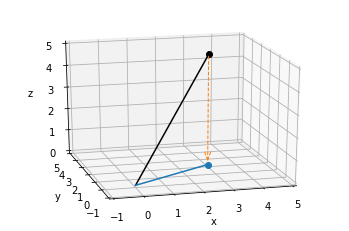

In [3]:
ax = setup_3d_axes()

# plot the vector (3, 2, 5)
origin = np.zeros((3,1))
point = np.array([[3,2,5]]).T
vector = np.hstack([origin, point])

ax.plot(*vector, color='k')
ax.plot(*point, color='k', marker='o');

# project the vector onto the x,y plane and plot it
xy_projection_matrix = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 0]])
projected_point = xy_projection_matrix @ point
projected_vector = xy_projection_matrix @ vector
ax.plot(*projected_vector, color='C0')
ax.plot(*projected_point, color='C0', marker='o')

# add dashed arrow showing projection
arrow_coords = np.concatenate([point, projected_point - point]).flatten()
ax.quiver3D(*arrow_coords, length=0.96, arrow_length_ratio=0.1, color='C1', linewidth=1, linestyle='dashed');

This simple geometric example projects the point (3,2,5) in 3D space onto a 2D space. The projection looks like a shadow cast by that point if the sun were directly above it.

From an information perspective, this projection has taken point x, y, z and removed the information about how far in the z direction the point was located; all we know now is its position in the x,y plane.
Applying our projection matrix to any point in x, y, z space will reduce it to a corresponding point on the x, y plane. The term for this is a `subspace`: the projection matrix projects points in the original space onto a `subspace` of lower dimension that the original.

## Projection as noise reduction

Another way to describe this "loss of information" or "projection into a subspace" is to say that projection reduces the rank (or "degrees of freedom") of the measurement – here from 3D to 2D.
On the other hand, if you know that measurement component in the z direction is just noise due to your measurement method, and all you care about are the x and y components, then projecting your 3D measurement into x, y plane could be seen as a form of `noise reduction`

Of course, it's unlikely that all the measurement noise will be concentrated in the z direction. Suppose instead that in order to make that measurement you had to pull a trigger on a measurement device, and the act of pulling the trigger causes the device to move a little. If you measure how trigger-pulling affects measurement device position, you could then "correct" your real measurements to "project out" the effect of trigger pulling. 

Here we'll suppose that the average effect of the trigger is to move the measurement device by (3, -1, 1):

In [4]:
trigger_effect = np.array([[3, -1, 1]]).T

Knowing that, we can compute a plane that is orthogonal to the effect of the trigger – using the fact that a plane through the origin has equation `Ax+By+Cz=0` given a normal vector (A, B, C), and project our real measurements onto the plane.

In [5]:
# compute the plane orthogonal to trigger_effect
x, y = np.meshgrid(np.linspace(-1, 5, 61), np.linspace(-1, 5, 61))
A, B, C = trigger_effect
z = (-A * x - B * y) / C

In [6]:
# cut off the plane below z=0 (just to ake the plot nicer)
mask = np.where(z >= 0)
x = x[mask]
y = y[mask]
z = z[mask]

Computing the projection matrix from the `trigger_effect` vector is done using `singular value decomposition` (SVD). With the projection matrix in place, we can project our original vector (3, 2, 5) to remove the effect of the trigger, and the plot it

In [7]:
# compute the projection matrix
U, S, V = svd(trigger_effect, full_matrices=False)
trigger_projection_matrix = np.eye(3) - U @ U.T

In [8]:
# project the vector onto orthogonal plane
projected_point = trigger_projection_matrix @ point
projected_vector = trigger_projection_matrix @ vector

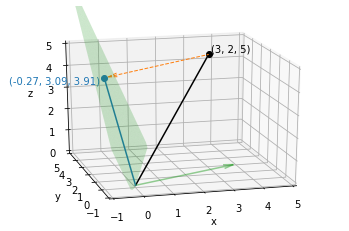

In [9]:
# plot the trigger effect and its orthogonal plane
ax = setup_3d_axes()
ax.plot_trisurf(x, y, z, color='C2', shade=False, alpha=0.25)
ax.quiver3D(*np.concatenate([origin, trigger_effect]).flatten(), arrow_length_ratio=0.1, color='C2', alpha=0.5)

# plot the original vector
ax.plot(*vector, color='k')
ax.plot(*point, color='k', marker='o')
offset = np.full((3,1), 0.1)
ax.text(*(point + offset).flat, '({}, {}, {})'.format(*point.flat), color='k')

# plot the projected vector
ax.plot(*projected_vector, color='C0')
ax.plot(*projected_point, color='C0', marker='o')
offset = np.full((3, 1), -0.2)
ax.text(*(projected_point + offset).flat, '({}, {}, {})'.format(*np.round(projected_point.flat, 2)), color='C0', horizontalalignment='right')

# add dashed arrow showing projection
arrow_coords = np.concatenate([point, projected_point - point]).flatten()
ax.quiver3D(*arrow_coords, length=0.96, arrow_length_ratio=0.1, color='C1', linewidth=1, linestyle='dashed');

Though the projected points vary in all three x, y, z directions, the set of projected points have only two `effective dimensions` (i.e., they are constrained to a plane)

## Signal-space projection (SSP)

Signal-space projection (SSP) is a way of estimating what the projection matrix should be, by comparing measurements with and without the signal of interest. Fx you can take additional "empty room" measurements that record activity at the sensors when no subject is present. By looking at the spatial pattern of activity across sensors in an empty room measurement, we can create one or more N-dimensional vector(s) giving the "direction(s)" of the environmental noise in sensor space. SSP is also often used for removing heartbeat and eye movement artifacts – in those cases, instead of empty room recordings the direction of the noise is estimated by detecting the artifacts, extracting epochs around them, and averaging. 

Once we know the noise vectors, we can create a hyperplane that is orthogonal to them, and construct a projection matrix to project our experimental recordings onto that hyperplane. The component of our measurements associated with environmental noise can be removed. 
The projection reduces the dimensionality of our data – we still have the same number of sensor signals, but they won't be `linearly independent` – but typically there are tens or hundreds of sensors and the noise subspace that we're eliminating has only 3-5 dimensions, so the loss of degrees of freedom is usually not problematic.

SSP has already been performed using empty room recordings, but the `projectors` are stored alongside the raw data and have not been applied yet. 

In [10]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample', 'sample_audvis_raw.fif')

raw = mne.io.read_raw_fif(sample_data_raw_file)
raw.crop(tmax=60).load_data()

Opening raw data file /Users/markyousef/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw  |  sample_audvis_raw.fif, n_channels x n_times : 376 x 36038 (60.0 sec), ~107.0 MB, data loaded>

the environmental noise vectors are computed using `principal component analysis (PCA)`

In [11]:
print(raw.info['projs'])

[<Projection  |  PCA-v1, active : False, n_channels : 102>, <Projection  |  PCA-v2, active : False, n_channels : 102>, <Projection  |  PCA-v3, active : False, n_channels : 102>]


In [12]:
first_projector = raw.info['projs'][0]
print(first_projector)

<Projection  |  PCA-v1, active : False, n_channels : 102>


In [13]:
print(first_projector.keys())

dict_keys(['kind', 'active', 'desc', 'data', 'explained_var'])


In [14]:
print(raw.proj)

False


In [15]:
print(first_projector['active'])

False


## Visualizing the effect of projectors

In [16]:
mags = raw.copy().crop(tmax=2).pick_types(meg='mag')

In [17]:
mags.plot(butterfly=True, proj=False)
mags.plot(butterfly=True, proj=True)

RuntimeError: libpng signaled error

<Figure size 0x0 with 5 Axes>

RuntimeError: libpng signaled error

<Figure size 0x0 with 5 Axes>

RuntimeError: libpng signaled error

<Figure size 0x0 with 5 Axes>